In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm.notebook import tqdm
import clip

# Check for GPU availability and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2rkpft8l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2rkpft8l
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
if not os.path.exists('vae-torch-celeba'):
    !git clone https://github.com/moshesipper/vae-torch-celeba.git

# Add the repository to Python's path to import the 'vae' module
sys.path.append('./vae-torch-celeba')
from vae import VAE, IMAGE_SIZE, celeb_transform, CELEB_PATH

# --- Load the VAE Model ---
# Path to your specific model file
MODEL_FILE = '/content/vae-torch-celeba/vae_model_20.pth'
print(f"Attempting to load model from: {MODEL_FILE}")

try:
    # Set weights_only=False to allow loading the model's Python class structure,
    # which is required for models saved this way in newer PyTorch versions.
    vae_model = torch.load(MODEL_FILE, map_location=device, weights_only=False)
    print(f"VAE Model '{os.path.basename(MODEL_FILE)}' loaded successfully.")
    vae_model.to(device)
    vae_model.eval()     # Set the model to evaluation mode - model is not changed

except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_FILE}")
    print("Please make sure the file is at the correct path in your Colab environment.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Cloning into 'vae-torch-celeba'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 50 (delta 22), reused 26 (delta 12), pack-reused 14 (from 1)
Receiving objects: 100% (50/50), 28.72 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (23/23), done.

CELEB_PATH ./data/ IMAGE_SIZE 150 LATENT_DIM 128 image_dim 67500
Attempting to load model from: /content/vae-torch-celeba/vae_model_20.pth
VAE Model 'vae_model_20.pth' loaded successfully.


In [ ]:
try:
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()
    print("CLIP model loaded successfully!")
except Exception as e:
    print(f"Error loading CLIP model: {e}")

# Define the normalization transform that CLIP expects for its image inputs
clip_normalize = transforms.Normalize(
    (0.48145466, 0.4578275, 0.40821073),
    (0.26862954, 0.26130258, 0.27577711)
)

100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 26.1MiB/s]


CLIP model loaded successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# --- Unzip and copy data if not already present ---
# This is the destination path required by the vae module's internal variables
celeba_data_path = "/content/vae-torch-celeba/data/celeba"

if not os.path.exists(os.path.join(celeba_data_path, "img_align_celeba")):
    print("CelebA data not found. Preparing from Google Drive...")
    # Ensure the target directory exists
    os.makedirs(celeba_data_path, exist_ok=True)

    # Copy annotation files
    !cp "/content/drive/MyDrive/UofT Classes/Grad 2025 Summer/ECE1508/celebA/list_attr_celeba.txt" "{celeba_data_path}/"
    !cp "/content/drive/MyDrive/UofT Classes/Grad 2025 Summer/ECE1508/celebA/list_eval_partition.txt" "{celeba_data_path}/"
    !cp "/content/drive/MyDrive/UofT Classes/Grad 2025 Summer/ECE1508/celebA/list_bbox_celeba.txt" "{celeba_data_path}/"
    !cp "/content/drive/MyDrive/UofT Classes/Grad 2025 Summer/ECE1508/celebA/list_landmarks_align_celeba.txt" "{celeba_data_path}/"
    !cp "/content/drive/MyDrive/UofT Classes/Grad 2025 Summer/ECE1508/celebA/identity_CelebA.txt" "{celeba_data_path}/"

    # Unzip image files
    zip_path = "/content/drive/MyDrive/UofT Classes/Grad 2025 Summer/ECE1508/celebA/img_align_celeba.zip"
    !unzip -q "{zip_path}" -d "{celeba_data_path}/"
    print("Data preparation complete.")
else:
    print("CelebA data already exists. Skipping preparation.")




In [ ]:
# --- Create DataLoader ---
# The root path is one level above the 'celeba' directory
dataset_root = "/content/vae-torch-celeba/data"
dataset = datasets.CelebA(root=dataset_root, transform=celeb_transform, download=False, split='all')
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

print(f"\nSuccessfully loaded CelebA dataset with {len(dataset)} images.")


Successfully loaded CelebA dataset with 202599 images.


In [ ]:
def edit_image_with_text(start_image, text_prompt, vae_model, clip_model, num_steps=200, lr=0.1):
    """
    Optimizes a VAE latent vector 'z' to match a text prompt via CLIP loss.
    """
    vae_model.eval()
    clip_model.eval()

    # Get the image size from the VAE module's variables
    try:
      from vae import IMAGE_SIZE
    except ImportError:
      IMAGE_SIZE = 64


    # Get Initial Latent Vector from the starting image
    with torch.no_grad():
        mu, log_var = vae_model.encode(start_image.to(device))
        z = mu.clone().detach().requires_grad_(True)

    # Get Target Text Features from CLIP
    with torch.no_grad():
        text_tokens = clip.tokenize([text_prompt]).to(device)
        target_text_features = clip_model.encode_text(text_tokens)
        target_text_features = F.normalize(target_text_features, p=2, dim=-1)

    # --- Setup Optimizer ---
    optimizer = optim.Adam([z], lr=lr)
    pbar = tqdm(range(num_steps), desc=f"Optimizing for '{text_prompt}'")

    for step in pbar:
        optimizer.zero_grad()

        # Decode latent z to a flattened image vector
        generated_flat = vae_model.decode(z)

        # The VAE outputs a flat [1, 12288] tensor. Reshape it to [1, 3, 64, 64].
        batch_size = z.shape[0] # This will be 1 in our case
        generated_image = generated_flat.view(batch_size, 3, IMAGE_SIZE, IMAGE_SIZE)

        upscaled_image = F.interpolate(generated_image, size=224, mode='bicubic', align_corners=False)
        normalized_image = clip_normalize(upscaled_image)

        # Get CLIP image features for the generated image
        current_image_features = clip_model.encode_image(normalized_image)
        current_image_features = F.normalize(current_image_features, p=2, dim=-1)

        # Calculate CLIP loss
        loss = (1 - (current_image_features @ target_text_features.T)).mean()

        # Backpropagate the loss to update the latent vector z
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # --- Generate Final Image ---
    with torch.no_grad():
        # Also reshape the final output for correct visualization
        final_flat = vae_model.decode(z)
        final_image = final_flat.view(1, 3, IMAGE_SIZE, IMAGE_SIZE)


    return final_image.squeeze(0).cpu()

def to_pil(tensor):
    """Converts a tensor to a PIL Image for display."""
    return transforms.ToPILImage()(tensor.clamp(0, 1))

Optimizing for 'A photo of a smiling woman with blonde hair':   0%|          | 0/150 [00:00<?, ?it/s]

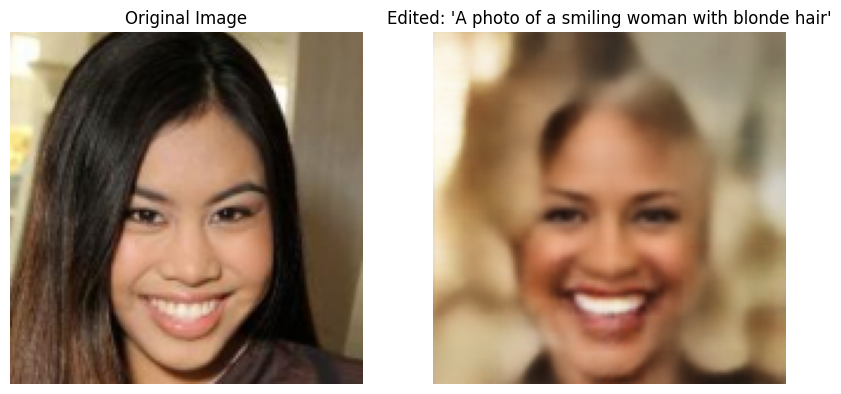


Running second example with prompt: 'A person wearing sunglasses'


Optimizing for 'A person wearing sunglasses':   0%|          | 0/150 [00:00<?, ?it/s]

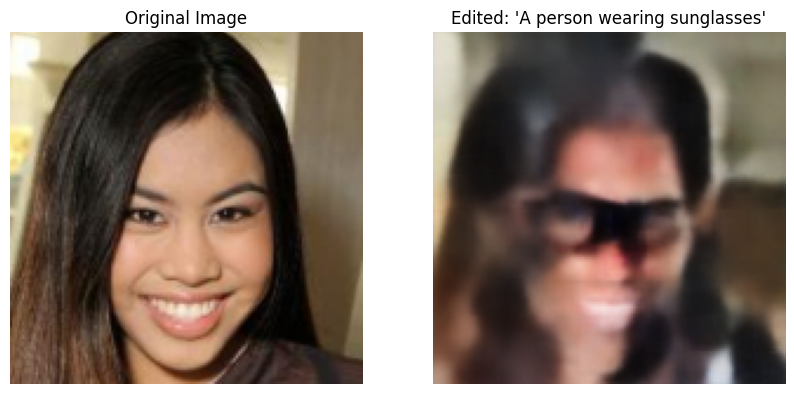

In [ ]:
# Hyperparameters
STARTING_IMAGE_IDX = 150              # Change this to try different faces
TEXT_PROMPT = "A photo of a smiling woman with blonde hair" # <--- Change the text prompt here!
NUM_STEPS = 150
LEARNING_RATE = 0.07

start_image_tensor, _ = dataset[STARTING_IMAGE_IDX]
start_image_tensor = start_image_tensor.unsqueeze(0) # Add batch dimension

# Edit
edited_image_tensor = edit_image_with_text(
    start_image=start_image_tensor,
    text_prompt=TEXT_PROMPT,
    vae_model=vae_model,
    clip_model=clip_model,
    num_steps=NUM_STEPS,
    lr=LEARNING_RATE
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(to_pil(start_image_tensor.squeeze(0)))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(to_pil(edited_image_tensor))
axes[1].set_title(f"Edited: '{TEXT_PROMPT}'")
axes[1].axis('off')

plt.show()

# Second Example
TEXT_PROMPT_2 = "A person wearing sunglasses"
print(f"\nRunning second example with prompt: '{TEXT_PROMPT_2}'")

edited_image_tensor_2 = edit_image_with_text(
    start_image=start_image_tensor,
    text_prompt=TEXT_PROMPT_2,
    vae_model=vae_model,
    clip_model=clip_model,
    num_steps=NUM_STEPS,
    lr=LEARNING_RATE
)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(to_pil(start_image_tensor.squeeze(0)))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(to_pil(edited_image_tensor_2))
axes[1].set_title(f"Edited: '{TEXT_PROMPT_2}'")
axes[1].axis('off')

plt.show()